# Julia Multithreading Gotchas

This notebook compiles a list of example code to illustrate Julia's [multithreading](https://docs.julialang.org/en/v1/manual/multi-threading/) feature. We focus on "performance gotchas" which are not well-documented (as of 2020). Note multithreading parallelism is different than Julia's [distributed parallelism](https://docs.julialang.org/en/v1/stdlib/Distributed/) in that the former always assume all data are present on a single computer. 

In [1]:
using Random
using BenchmarkTools
using LinearAlgebra
using Plots
using ThreadPools

## How to access multithreading feature

Before starting Julia (REPL or notebook), type 

    `export JULIA_NUM_THREADS=8`

then verify you indeed have multiple active threads:

In [2]:
Threads.nthreads()

8

## Gotcha 1: Race Conditions - Wrong Answers!

+ A race condiion is when 2 or more threads modify the same variable simultaneously, so you get the wrong answer. 
+ Julia makes no effort to check if your code is thread-safe
+ There is no good way to debug one!! 

In [3]:
function unsafe_sum(x)
    s = 0.0
    Threads.@threads for i in eachindex(x)
        s += x[i]
    end
    return s
end

Random.seed!(2020)
x = rand(100000)
@show unsafe_sum(x)
@show unsafe_sum(x);

unsafe_sum(x) = 6419.710605861014
unsafe_sum(x) = 7549.242253314164


Answers don't match! There is a race condition! To debug race conditions, I suggest using [Threads.SpinLock()](https://docs.julialang.org/en/v1/base/multi-threading/#Base.Threads.SpinLock). 

In [4]:
function debug_unsafe_sum(x::AbstractVector)
    s = 0.0
    m = Threads.SpinLock()
    Threads.@threads for i in eachindex(x)
        lock(m)
        s += x[i] # surround possible race condition with locks
        unlock(m)
    end
    return s
end

@show debug_unsafe_sum(x)
@show debug_unsafe_sum(x);

debug_unsafe_sum(x) = 49938.497845646096
debug_unsafe_sum(x) = 49938.49784564645


**Conclusion:** `s += x[i]` is causing the race condition! This is obvious: if 2 threads are *simultaneously* updating `s`, only one thread's result will be recorded. Since we have 8 threads, only ~1/8 of all operations are updated and the rest is lost. That's why our `unsafe_sum` returned a value that's about $1/8$ of the correct answer. 

To fix this, force each thread to modify a different value. 

In [5]:
function safe_sum(x::AbstractVector)
    threads = Threads.nthreads()
    s = zeros(threads)
    Threads.@threads for i in eachindex(x)
        s[Threads.threadid()] += x[i] # each thread adds to a different location
    end
    return sum(s) # return sum of each thread
end

@show safe_sum(x)
@show safe_sum(x);

safe_sum(x) = 49938.49784564629
safe_sum(x) = 49938.49784564629


Finally we resolved the race condition. Let's check timings:

In [6]:
@btime safe_sum($x)
@btime debug_unsafe_sum($x)
@btime sum($x);

  36.471 μs (42 allocations: 5.66 KiB)
  6.095 ms (200043 allocations: 3.06 MiB)
  12.474 μs (0 allocations: 0 bytes)


We are faster than using locks (which is single threaded and requires extra bookkeeping), but slower than Julia's built-in `sum` command. That is because Julia's built-in `sum` uses many [performance annotations](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-annotations) like `@inbounds` and `@simd`. The latter stands for single-instruction multiple data, which is more suitable parallel mechanism for calculating sum of vectors.

## Gotcha 2: False sharing - Not-actually-parallel parallel code

+ Threads shouldn’t be modifying things that are “very close” (i.e. 8 bytes) in memory
+ Julia’s LLVM may or may not save you (as you can verify with `@code_native`)

![title](false-sharing-illustration.png)

[Image credit](https://haryachyy.wordpress.com/2018/06/19/learning-dpdk-avoid-false-sharing/)

In [7]:
# see post https://discourse.julialang.org/t/editing-an-array-with-multiple-threads/25364/9
function f(spacing)
    n = 1000000
    x = rand(n)

    s = zeros(Threads.nthreads()*spacing) # sum of x
    c = zeros(Threads.nthreads()*spacing) # count additions in each thread

    Threads.@threads for i = 1:n
        s[Threads.threadid()*spacing] += x[i]
        c[Threads.threadid()*spacing] += 1
    end
    return sum(s), c
end

@btime f(1);
@btime f(8);

  17.791 ms (45 allocations: 7.64 MiB)
  1.212 ms (45 allocations: 7.64 MiB)


**Conclusion:** The `safe_sum` function in Gotcha 1 *is vulnerable to false sharing*, but Julia's LLVM saved us there. In more complicated examples, you need to add spacings. 

## Gotcha 3: Oversubscription - parallelism on top of parallelism

This can happen when

+ When code performs parallel operations which themselves call other parallel operations (e.g. BLAS + multithreading).
+ You start Julia with more threads than the number of physical cores on your CPU

**Note:** Not all oversubscriptions are bad. For instance, intensive I/O operations can benefit with more threads than CPU cores because loading/writing data to/from disk is so slow that the CPU is basically idle most of the time. In my experience, oversubscription is *bad* for tasks where everything is loaded in memory, and good otherwise. 

In [8]:
# Performs C[i] = A[i] * B[i] where A[i], B[i], C[i] are matrices
function test_multiply!(C, A, B)
    Threads.@threads for i in eachindex(C)
        id = Threads.threadid()
        mul!(C[id], A[id], B[id])
    end
end

# simulate data
Random.seed!(2020)
A = [rand(100, 100) for _ in 1:100]
B = [rand(100, 100) for _ in 1:100]
C = [rand(100, 100) for _ in 1:100];

# 8 BLAS threads (default)
BLAS.set_num_threads(8)
@btime test_multiply!($C, $A, $B)

# 1 BLAS thread
BLAS.set_num_threads(1)
@btime test_multiply!($C, $A, $B);

  3.539 ms (41 allocations: 5.53 KiB)
  807.662 μs (40 allocations: 5.50 KiB)


**Conclusion:** If you forgot to change BLAS threads (8 by default), your for loop is automatically **4 times** slower!

## Gotcha 4: Non-uniform tasks + static scheduler = bottleneck is singlethreaded

`@threads for` currently employ a [static](https://docs.julialang.org/en/v1/base/multi-threading/#Base.Threads.@threads) scheduler (but I think more options is coming in near future). This means each thread 1 gets the first $x$ jobs, thread 2 gets the next $x$ jobs...etc. If different $i$ takes different times, then eventually your code will become single threaded. For now, I recommend [ThreadPools.jl](https://github.com/tro3/ThreadPools.jl) for getting a dynamically scheduled for loop. 

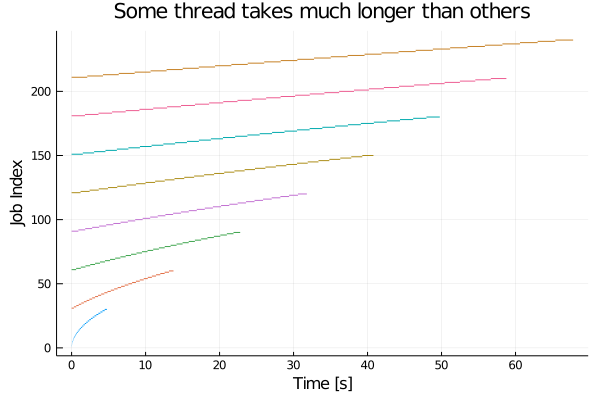

In [9]:
# static scheduler
pool = logtforeach(x -> sleep(0.01*x), 1:240) 
plot(pool, title="Some thread takes much longer than others")

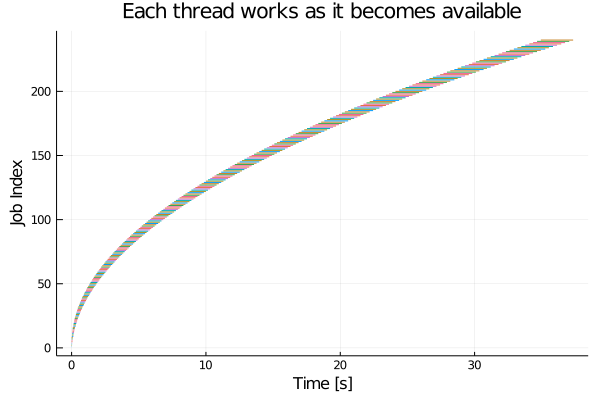

In [10]:
# dynamic scheduler
pool = logqforeach(x -> sleep(0.01*x), 1:240) 
plot(pool, title="Each thread works as it becomes available")

## Gotcha 5: Memory Allocation Really Does Matter

Chris Rackauckas explained in his [parallel computing course](https://github.com/mitmath/18337) that micro-allocations (i.e. optimize for memory and allocations) only matter for $\mathcal{O}(n)$ problems. **In Julia this is only true for serial code!!**

The example code below is from https://mitmath.github.io/18337/lecture2/optimizing


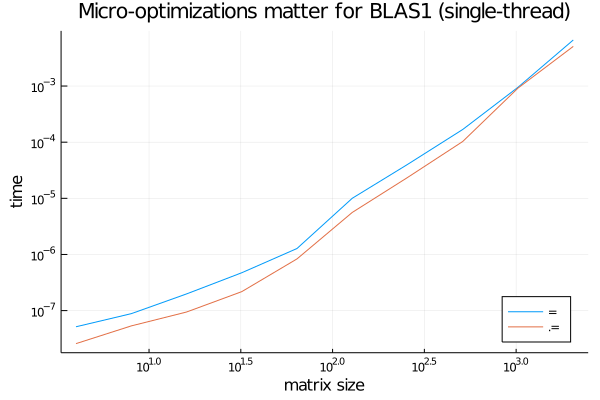

In [2]:
# element-wise scaling O(n)
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A .* $B
    t2 = @belapsed ($C .= $A .* $B)
    t1,t2
end

BLAS.set_num_threads(1) # remember gotcha 3!!!!!!
ns = 2 .^ (2:11)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

plot(ns,alloc,label="=",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations matter for BLAS1 (single-thread)",
     xlabel="matrix size", ylabel="time")
plot!(ns,noalloc,label=".=")

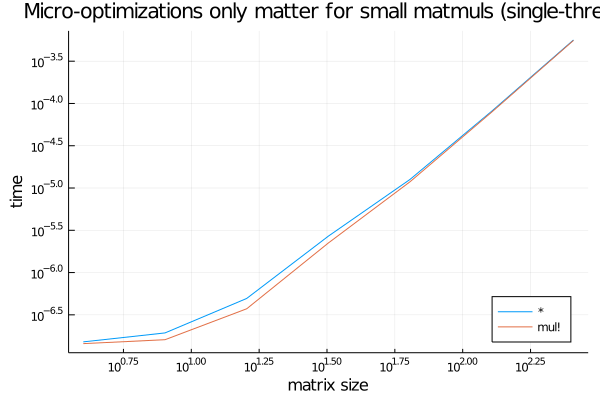

In [3]:
# matrix multiply O(n³)
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A*$B
    t2 = @belapsed mul!($C,$A,$B)
    t1,t2
end

BLAS.set_num_threads(1) # remember gotcha 3!!!!!!
ns = 2 .^ (2:8)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

plot(ns,alloc,label="*",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations only matter for small matmuls (single-thread)",
     xlabel="matrix size", ylabel="time")
plot!(ns,noalloc,label="mul!")

**Conclusion:** For single threaded programs, memory optimization matters only for BLAS 1 operations.

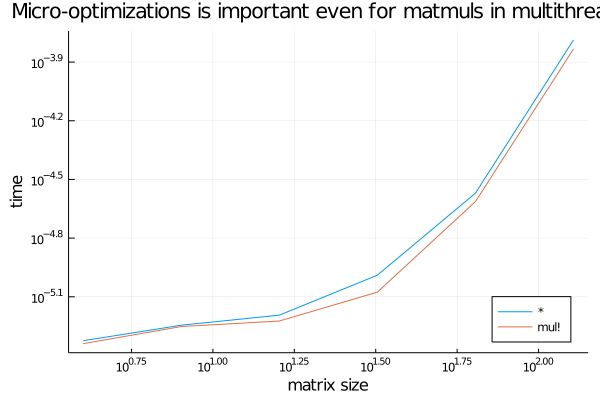

In [5]:
# a bunch of matrix multiply in multithreaded
function alloc_timer(n)
    A = [rand(n, n) for _ in 1:8]
    B = [rand(n, n) for _ in 1:8]
    C = [rand(n, n) for _ in 1:8]
    t1 = @belapsed begin
        Threads.@threads for i in eachindex($C)
            $C[i] = $A[i]* $B[i]
        end
    end
    t2 = @belapsed begin
        Threads.@threads for i in eachindex($C)
            mul!($C[i], $A[i], $B[i])
        end
    end
    t1,t2
end

BLAS.set_num_threads(1) # remember gotcha 3!!!!!!
ns = 2 .^ (2:7)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

plot(ns,alloc,label="*",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations is important even for matmuls in multithreading",
     xlabel="matrix size", ylabel="time")
plot!(ns,noalloc,label="mul!")

**Conclusion:** ANY extra allocation memory are completely detrimental to performance. Even a few KB which takes no time at all for single-threaded programs can completely kill performance once you use `@threads`. This is because garbage collection in Julia is (still) single-threaded, so you really don't want to trigger it.
